# Plots

## Setup

In [ ]:
import os

# Prepend TeX bin path to the PATH environment variable
#os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib inline

<function LinearScale.__init__ at 0x115812840>
<function LogScale.__init__ at 0x1158132e0>
<function SymmetricalLogScale.__init__ at 0x115813c40>
<function AsinhScale.__init__ at 0x115818400>
<function LogitScale.__init__ at 0x115818b80>
<function FuncScale.__init__ at 0x115812ca0>
<function FuncScaleLog.__init__ at 0x115813600>
<function Artist.get_agg_filter at 0x115df4cc0>
<function Artist.get_alpha at 0x115df44a0>
<function Artist.get_animated at 0x115df45e0>
<function Artist.get_children at 0x115d9b740>
<function Artist.get_clip_box at 0x115df4860>
<function Artist.get_clip_on at 0x115df47c0>
<function Artist.get_clip_path at 0x115df4900>
<function Artist.get_cursor_data at 0x115df5a80>
<function Artist.get_figure at 0x115df4220>
<function Artist.get_gid at 0x115d9bce0>
<function Artist.get_in_layout at 0x115df4680>
<function Artist.get_label at 0x115df51c0>
<function Artist.get_mouseover at 0x115df5bc0>
<function Artist.get_path_effects at 0x115df4180>
<function Artist.get_picker

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 7.00697, 7.00697
#rcParams['figure.figsize'] = 3.337, 3.337

TINY_SIZE = 5
FOOTNOTE_SIZE = 7
SMALL_SIZE = 8
NORMAL_SIZE = 9
LARGE_SIZE = 10

rcParams['font.size'] = NORMAL_SIZE


In [4]:
method_order = [ "fine-tuning", "lora", "ia3","prompt-tuning", "pre-trained"]

method_mapping = {
    "pre-trained": "Baseline",
    "fine-tuning": "Full fine-tuning",
    "lora": "LoRA",
    "ia3": "(IA)\\textsuperscript{3}",
    "prompt-tuning": "Prompt tuning",
    }

color_map = {
    "fine-tuning": "C0",
    "lora": "C1",
    "ia3": "C2",
    "prompt-tuning": "C3",
    "pre-trained": "C4",
    }

model_order = [
    "codegen-350M-multi",
    "codegen2-1B_P",
    "starcoder2-3b",
    "codegen2-3_7B_P",
    "CodeLlama-7b-hf",
    "codegen2-7B_P",
    "starcoder2-7b",
    "starcoderbase",
    "starcoder2-15b",
    "codegen2-16B_P"]

model_mapping = {
    "codegen-350M-multi": "CodeGen-350M-multi",
    "codegen2-1B_P": "CodeGen2-1B",
    "codegen2-3_7B_P": "CodeGen2-3.7B",
    "codegen2-7B_P": "CodeGen2-7B",
    "codegen2-16B_P": "CodeGen2-16B",
    "CodeLlama-7b-hf": "CodeLlama-7B",
    "starcoderbase": "StarCoderBase",
    "starcoder2-3b": "StarCoder2-3B",
    "starcoder2-7b": "StarCoder2-7B",
    "starcoder2-15b": "StarCoder2-15B"
    }

column_mapping = {
    "valid_syntax": "Valid syntax",
    "scores": "CodeBLEU",
    "coverage_runnable": "Pass@1",
    "coverage_instruction": "Instruction coverage",
    "coverage_branch": "Branch coverage"
}


## Figures

In [5]:
import os
os.makedirs("../figures", exist_ok=True)

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path('../data/')

In [7]:
datasets = {
    'methods2test_runnable': '\\textsc{Methods2Test\\textsubscript{runnable}}',
    #'humaneval-x': '\\textsc{HumanEval-X\\textsubscript{java}}',
}

columns = ['valid_syntax', 'scores', 'coverage_runnable', 'coverage_instruction', 'coverage_branch']

In [8]:
model_trainable_params =  pd.read_csv(DATA_DIR / 'params_data.csv', index_col=0)
model_trainable_params.index = model_trainable_params.index.str.split('/').str[1]
model_trainable_params = model_trainable_params.loc[model_mapping.keys()]
model_trainable_params = model_trainable_params.apply(lambda x: x.str.replace(',', ''))
model_trainable_params = model_trainable_params.astype(int)

In [9]:
data = {}

for dataset in datasets.keys():
    dataset_dir = DATA_DIR / dataset
    
    coverage_branch = pd.read_csv(dataset_dir / 'coverage_branch.csv', index_col=0)
    coverage_branch.index = coverage_branch.index.str.split('/').str[1]
    coverage_branch = coverage_branch.loc[model_mapping.keys()]
    
    coverage_instruction = pd.read_csv(dataset_dir / 'coverage_instruction.csv', index_col=0)
    coverage_instruction.index = coverage_instruction.index.str.split('/').str[1]
    coverage_instruction = coverage_instruction.loc[model_mapping.keys()]
    
    coverage_runnable = pd.read_csv(dataset_dir / 'coverage_runnable.csv', index_col=0)
    coverage_runnable.index = coverage_runnable.index.str.split('/').str[1]
    coverage_runnable = coverage_runnable.loc[model_mapping.keys()]
    
    
    scores = pd.read_csv(dataset_dir / 'scores.csv', index_col=0)
    scores.index = scores.index.str.split('/').str[1]
    scores = scores.loc[model_mapping.keys()]
    
    valid_syntax = pd.read_csv(dataset_dir / 'valid_syntax.csv', index_col=0)
    valid_syntax.index = valid_syntax.index.str.split('/').str[1]
    valid_syntax = valid_syntax.loc[model_mapping.keys()]
    
    data[dataset] = pd.concat([valid_syntax, scores, coverage_runnable, coverage_instruction, coverage_branch], axis=1, keys=columns)
    

#concat all datasets
data = pd.concat(data, axis=1)
data = data.astype(float).round(2)

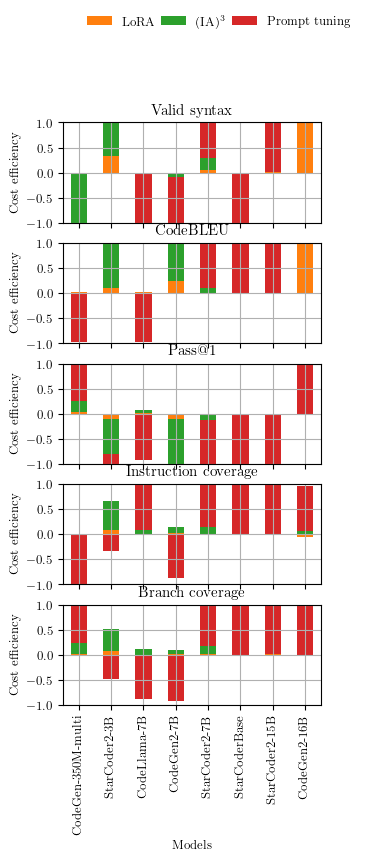

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(7.00697, 7.00697), sharex=True, sharey=True)
axs = axs.flatten()  # To index subplots in a flat list

method_colors = [color_map[name] for name in method_order if name not in ["pre-trained", "fine-tuning"]]
#handles_order =[dict_legends[lo] for lo in method_order if lo not in ["pre-trained", "fine-tuning"]]
method_names = [method_mapping[name] for name in method_order if name not in ["pre-trained", "fine-tuning"]]
model_names = [model_mapping[name] for name in model_order]
column_names = [column_mapping[name] for name in columns]

trainable_params_frac_df = model_trainable_params.div(model_trainable_params["pre-trained"],axis=0)
trainable_params_frac_df = trainable_params_frac_df.drop(index="codegen2-1B_P").drop(index="codegen2-3_7B_P")
temp_data = data.drop(index="codegen2-1B_P").drop(index="codegen2-3_7B_P")
model_names.remove('CodeGen2-1B')
model_names.remove('CodeGen2-3.7B')

for idx, metric in enumerate(["valid_syntax", "scores", "coverage_runnable", "coverage_instruction", "coverage_branch"]):
      increase_df = temp_data["methods2test_runnable"][metric].sub(temp_data["methods2test_runnable"][metric]["pre-trained"],axis=0)
      relative_increase_df = increase_df.div(trainable_params_frac_df, axis=0)
      relative_increase_normalized = relative_increase_df.div(relative_increase_df.abs().sum(axis=1), axis=0)  

      ax = axs[idx]

      relative_increase_normalized[["lora", "ia3", "prompt-tuning"]].sort_index(key=lambda x: x.map({v: i for i, v in enumerate(model_order)}))\
            .plot( kind='bar', stacked=True, ax=ax, legend=False, color=method_colors)

      if idx == len(axs) - 1: 
            ax.set_xticklabels(model_names, rotation=90, ha='center')
            ax.set_xlabel('Models')
      else:
            ax.set_xticklabels([])  # hide x labels for top row
    
      ax.set_ylabel('Cost efficiency')
      ax.grid(True)
      ax.set_ylim(bottom=-1, top=1)
      ax.set_title(column_mapping[metric])

# Show and save the plot
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
dict_legends = dict(zip(labels, handles))
handles_order =[dict_legends[lo] for lo in method_order if lo not in ["pre-trained", "fine-tuning"]]
method_names = [method_mapping[name] for name in method_order if name not in ["pre-trained", "fine-tuning"]]
fig.legend(handles_order, method_names, loc='lower right', ncol=3, frameon=False, columnspacing=0.5, bbox_to_anchor=(0,0.99,1.02,0.2),)
#fig.supylabel("Relative importance", fontsize=12)
#7.00697in 3.3374in 8.66367in
fig.set_size_inches(w=3.3374, h=(7.566))
plt.show()
fig.tight_layout()
fig.savefig('../figures/relative_importance.pdf', bbox_inches='tight')
ax.xaxis.set_tick_params(pad=-2.5)
fig.savefig('../figures/relative_importance.pgf', bbox_inches='tight')
